# 项目介绍

## 背景介绍  
信用贷（原蚂蚁借呗）是支付宝平台提供的小额信用贷款服务。互联网小额信用贷款平台（简称网贷平台）根据风险控制和准入标准对支付宝实名用户进行筛选，为筛选出的优质客户提供不同的借款额度。网贷平台的快速发展得益于互联网平台建立了自建的场景流量信用评分体系，形成了获客和贷款的闭环体验。  

项目来自于国内网络借贷行业的贷款风险数据，包括：  

- 1.信用违约标签（因变量）  
- 2.建模所需的基础与加⼯字段（自变量）  
- 3.相关用户的网络行为原始数据  

本着保护借款⼈隐私以及知识产权的目的，数据字段已经过脱敏处理。  
## 数据简介  

- 1.数据编码为GBK。  
- 2.数据包括3万条训练集和3万条测试集。  
- 3.所有训练集(含Training)，测试集(含Test)都包括3个csv文件。  

### 数据信息  
**Master (信贷客户的申报信息和部分第三方数据，以及需要预测的目标标签target。每一行代表一笔借据，即一条成交借款样本，每个样本包含200多个字段)**  

- 1.idx：每笔借款的unique key，可与另外2个文件里的idx相匹配  
- 2.UserInfo_*：借款人特征字段  
- 3.WeblogInfo_*：网络行为字段  
- 4.Education_Info*：学历学籍字段  
- 5.ThirdParty_Info_PeriodN_*：第三方数据时间段N字段  
- 6.SocialNetwork_*：社交网络字段  
- 7.LinstingInfo：借款成交时间  
- 8.Target：违约标签（1 = 贷款违约，0 = 正常还款）。测试集里不包含target字段。  

**Log_Info（信贷客户在网贷平台上的登陆记录）**  

- 1.ListingInfo：借款成交时间  
- 2.LogInfo1：操作代码  
- 3.LogInfo2：操作类别  
- 4.LogInfo3：登陆时间  
- 5.idx：每一笔借款的unique key  

**Userupdate_Info（部分客户在网贷平台上的修改记录）**  
         
- 1.ListingInfo1：借款成交时间  
- 2.UserupdateInfo1：修改内容  
- 3.UserupdateInfo2：修改时间  
- 4.idx：每⼀笔借款的unique key  
 

## 案例总体思路  

### 数据清洗与预处理  
- 对缺失值的多维度的处理  
- 对离群点的剔除方法  
- 对变量进行归一化处理（文本处理）  
### 特征工程  
- 地理位置信息  
- 成交时间  
- 类别编码  
- 组合特征  
### 特征选择  
- 特征相关性  
- 特征重要度排序  
### 类别不平衡处理  
- 代价敏感学习与过采样  
### 模型设计与优化  
- 逻辑回归  
- XGBoost  
- LightGBM  
- 模型融合  


## 案例流程       
### 数据清洗  
**缺失值的多维度处理；**  

- 对于每一列来说，统计每一列的数据缺失比例：  
- 对于每一行来说，也统计一下缺失值的个数并按缺失值大小从小到大排序，训练集和测试集是否表现出近乎一样的分布？如略有不同，是否这部分数据可以认为是离群点？  
- 还可以利用Xgboost在原始的训练集上训练得出每一个原始特征的重要程度列表，排序以后，取前n个重要的原始特征（根据原始特征的数量，可以调整抽取重要特征的个数），然后将有缺失值的样本拿出来进行统计分析。举例：如果其缺失的原始特征中有10个特征都是前20个重要特征，说明这个样本为异常值，可以剔除掉。  
 
**剔除常变量**  
         
- 原始数据中有190维数值型特征，计算出这些数值型特征的标准差，标准差几乎为零的特征说明在这一维度上的取值几乎为常数，故其没有区分度。可以设置一个阈值，剔除掉标准差小于某个阈值的特征项。  

**变量的归一化（文本处理）**  
- 字符大小写转换  
    - 比如，Userupdate_Info表中的UserupdateInfo1字段，属性取值为英文字符，包含了大小写，如“_QQ”和“_qQ”，很明显是同一种取值，可以将所有字符统一转换为小写。  
- 空格符号处理  
    - 比如，Master表中UserInfo_9字段的取值包含了空格字符，如“中国移动”和“中国移动     ”，它们是同一种取值，需要将空格符去除。  
- 城市名处理  
    - 比如，UserInfo_8包含有“重庆”、“重庆市”等取值，它们实际上是同一个城市，需要把字符中的“市”全部去掉。去掉“市”之后，城市数由 600 多下降到 400 多。  

### 特征工程  
- （省份）地理位置的处理方法举例  
    - UserInfo_7和UserInfo_19是省份信息，其余为城市信息。统计每个省份和城市的违约率。  
    - 选择违约率超过某个阈值的省份或直辖市，例如四川，湖南，湖北，吉林，天津，山东等等，用这些省份或直辖市构造几个二值特征：“是否为四川省”，“是否为湖南省”........“是否为山东省”，取值为 0或1 。  
- （市级）地理位置处理方法举例  
    - （1）按照城市等级合并  
        - 由于市级城市数量过多，如果按照类别型特征直接处理，进行独热编码后，会得到很高维度的稀疏特征，这样训练的时候，每一维度的城市特征是学不到什么有用的权重的。故不可采取这种办法，除了上述按违约率较高的省份或直辖市单独成为一个维度，违约率过低的合并成一个维度以外，还可以将所有城市按照经济等级分层划分成不同的层次，这样既科学，也能很好的降低城市这一特征维度。具体操作如下，例如一线城市北京，上海，广州，深圳合并，赋值为1，同样的，二线城市合并为2，三线城市合并为3，以此类推。  
    - （2）经纬度特征的引入  
        - 上述几种对地理位置信息的处理都是基于类别型的，我们还可以把类别型特征转化为数值型特征，通过引入经纬度来实现。比如，将地理位置特征变为经度和纬度两个特征，北京市可以用经度39.92，纬度116.46，两个特征替换。  
    - （3）构建地理位置的组合特征（**地理位置差异特征**）  
        - 比如，UserInfo_2,UserInfo_4,UserInfo_7,UserInfo_8,UserInfo_20等都是城市地理信息，可以两两比较，构造diff_24(UserInfo_2，UserInfo_4)，当这两个特征值一样时，diff_12为1，否则为0。  
        
以上几种对地理位置的处理方法，可以根据效果选择最适合的方法。  

- 成交时间  
    - （1）将成交时间字段Listinginfo处理成数值型的特征，直接当成连续值来处理。  
    - （2）将成交时间离散化，按照一定的间隔（如以10天为一个区间），即将日期0~10离散为1，日期11~20离散为2，以此类推。  

- 其他特征  
    - UpadteInfo表特征  
        - 根据这个表提供的信息，可以从中抽取用户修改信息次数，修改信息时间到成交时间的跨度，每种信息的修改次数等等特征，至于提取的哪个特征具有区别性可以做简单的统计分析，比如每种特征下违约率的分布是否由于不同的取值发生明显的变化。  
    - LogInfo表特征  
        - 从登录信息表里可以提取用户的登录信息特征，比如登录天数，平均登录间隔，以及每一种操作代码次数等等特征。  

### 特征选择  
除了课上讲的一些特征相关性分析方法外，比较高效的一种方法是基于模型的特征排序方法。这种方法有一个好处：模型学习的过程和特征选择的过程是同时进行的，比如基于 xgboost 来做特征选择，xgboost模型训练完成后可以输出特征的重要性，据此可以保留 TopN个特征，从而也可以达到特征选择的目的。  

### 类别不平衡问题  
赛题数据的类别比例接近13:1，可以尝试采用两种解决类别不平衡问题的方法，代价敏感学习和过采样。分析本案例适用哪种方法。  

### 建模与模型融合  
- Logistic regression + L1正则化  
- randomforest  
- Xgboost + bagging  
- LightGBM  
- 多模型blending（模型融合）

# 方案实现

## 工具库引入与数据读取

In [142]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [143]:
dataset_path = r'./data/train'

train_master = pd.read_csv(os.path.join(dataset_path, 'Master_Training_Set.csv'), encoding='gbk')
train_userupdateinfo = pd.read_csv(os.path.join(dataset_path, 'Userupdate_Info_Training_Set.csv'), encoding='gbk')
train_loginfo = pd.read_csv(os.path.join(dataset_path, 'LogInfo_Training_Set.csv'), encoding='gbk')

In [144]:
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint

Pretty printing has been turned OFF


## 数据一览

**借款人信息**

In [145]:
train_master.head() ## 借款人的一些信息
train_master.info()
train_master.shape

,Idx,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_1,WeblogInfo_2,WeblogInfo_3,WeblogInfo_4,WeblogInfo_5,...,SocialNetwork_10,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_15,SocialNetwork_16,SocialNetwork_17,target,ListingInfo
0,10001,1.0,深圳,4.0,深圳,NaN,1.0,NaN,1.0,1.0,...,222,-1,0,0,0,0,0,1,0,2014/3/5
1,10002,1.0,温州,4.0,温州,NaN,0.0,NaN,1.0,1.0,...,1,-1,0,0,0,0,0,2,0,2014/2/26
2,10003,1.0,宜昌,3.0,宜昌,NaN,0.0,NaN,2.0,2.0,...,-1,-1,-1,1,0,0,0,0,0,2014/2/28
3,10006,4.0,南平,1.0,南平,NaN,NaN,NaN,NaN,NaN,...,-1,-1,-1,0,0,0,0,0,0,2014/2/25
4,10007,5.0,辽阳,1.0,辽阳,NaN,0.0,NaN,1.0,1.0,...,-1,-1,-1,0,0,0,0,0,0,2014/2/27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 228 entries, Idx to ListingInfo
dtypes: float64(38), int64(170), object(20)
memory usage: 52.2+ MB


(30000, 228)

**借款成交时间 , 修改内容 ,修改时间**

In [146]:
train_userupdateinfo.head(20)   ###借款成交时间 , 修改内容 ,修改时间
train_userupdateinfo.info()
train_userupdateinfo.shape

,Idx,ListingInfo1,UserupdateInfo1,UserupdateInfo2
0,10001,2014/03/05,_EducationId,2014/02/20
1,10001,2014/03/05,_HasBuyCar,2014/02/20
2,10001,2014/03/05,_LastUpdateDate,2014/02/20
3,10001,2014/03/05,_MarriageStatusId,2014/02/20
4,10001,2014/03/05,_MobilePhone,2014/02/20
5,10001,2014/03/05,_MobilePhone,2014/02/20
6,10001,2014/03/05,_QQ,2014/02/20
7,10001,2014/03/05,_ResidenceAddress,2014/02/20
8,10001,2014/03/05,_ResidencePhone,2014/02/20
9,10001,2014/03/05,_ResidenceTypeId,2014/02/20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372463 entries, 0 to 372462
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Idx              372463 non-null  int64 
 1   ListingInfo1     372463 non-null  object
 2   UserupdateInfo1  372463 non-null  object
 3   UserupdateInfo2  372463 non-null  object
dtypes: int64(1), object(3)
memory usage: 11.4+ MB


(372463, 4)

**借款成交时间 ,操作代码 ,操作类别 ,登陆时间**

In [147]:
train_loginfo.head(20) ##借款成交时间 ,操作代码 ,操作类别 ,登陆时间
train_loginfo.shape
train_loginfo.isnull().sum().sort_values(ascending=False).head(10) # 缺失值统计

,Idx,Listinginfo1,LogInfo1,LogInfo2,LogInfo3
0,10001,2014-03-05,107,6,2014-02-20
1,10001,2014-03-05,107,6,2014-02-23
2,10001,2014-03-05,107,6,2014-02-24
3,10001,2014-03-05,107,6,2014-02-25
4,10001,2014-03-05,107,6,2014-02-27
5,10001,2014-03-05,107,6,2014-03-04
6,10001,2014-03-05,1,1,2014-02-20
7,10001,2014-03-05,1,20,2014-02-20
8,10001,2014-03-05,12,0,2014-02-20
9,10001,2014-03-05,1,2,2014-02-20


(580551, 5)

Idx             0
Listinginfo1    0
LogInfo1        0
LogInfo2        0
LogInfo3        0
dtype: int64

### 数据探索分析

**用户登录信息和用户更新信息没有缺失值，不用处理**

In [148]:
list(train_master.columns)

['Idx', 'UserInfo_1', 'UserInfo_2', 'UserInfo_3', 'UserInfo_4', 'WeblogInfo_1', 'WeblogInfo_2', 'WeblogInfo_3', 'WeblogInfo_4', 'WeblogInfo_5', 'WeblogInfo_6', 'WeblogInfo_7', 'WeblogInfo_8', 'WeblogInfo_9', 'WeblogInfo_10', 'WeblogInfo_11', 'WeblogInfo_12', 'WeblogInfo_13', 'WeblogInfo_14', 'WeblogInfo_15', 'WeblogInfo_16', 'WeblogInfo_17', 'WeblogInfo_18', 'UserInfo_5', 'UserInfo_6', 'UserInfo_7', 'UserInfo_8', 'UserInfo_9', 'UserInfo_10', 'UserInfo_11', 'UserInfo_12', 'UserInfo_13', 'UserInfo_14', 'UserInfo_15', 'UserInfo_16', 'UserInfo_17', 'UserInfo_18', 'UserInfo_19', 'UserInfo_20', 'UserInfo_21', 'UserInfo_22', 'UserInfo_23', 'UserInfo_24', 'Education_Info1', 'Education_Info2', 'Education_Info3', 'Education_Info4', 'Education_Info5', 'Education_Info6', 'Education_Info7', 'Education_Info8', 'WeblogInfo_19', 'WeblogInfo_20', 'WeblogInfo_21', 'WeblogInfo_23', 'WeblogInfo_24', 'WeblogInfo_25', 'WeblogInfo_26', 'WeblogInfo_27', 'WeblogInfo_28', 'WeblogInfo_29', 'WeblogInfo_30', 'Webl

In [149]:
## 加载微软雅黑中文字体
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r"./SIMHEI.TTF",size=12)

%matplotlib inline
n_null_rate = train_master.isnull().sum().sort_values(ascending=False)/30000
n_null_rate.head(20)


WeblogInfo_1     0.967667
WeblogInfo_3     0.967667
UserInfo_12      0.630300
UserInfo_13      0.630300
UserInfo_11      0.630300
WeblogInfo_20    0.268333
WeblogInfo_21    0.102467
WeblogInfo_19    0.098767
WeblogInfo_2     0.055267
WeblogInfo_4     0.055033
WeblogInfo_5     0.055033
WeblogInfo_6     0.055033
UserInfo_2       0.010067
UserInfo_4       0.008933
WeblogInfo_32    0.008433
WeblogInfo_37    0.008433
WeblogInfo_35    0.008433
WeblogInfo_34    0.008433
WeblogInfo_33    0.008433
WeblogInfo_29    0.008433
dtype: float64

In [150]:
## 去掉缺失比例接近百分之百的字段
train_master.drop(['WeblogInfo_1' ,'WeblogInfo_3'],axis=1,inplace=True)

array([nan,  0.,  1.])

,missing,not_missing
target,,
0,17386,10416
1,1523,675


<Axes: xlabel='target'>

Text(0.5, 1.0, '有无这个特征对结果的影响')

Text(0.5, 0, '有无')

Text(0, 0.5, '违约情况')

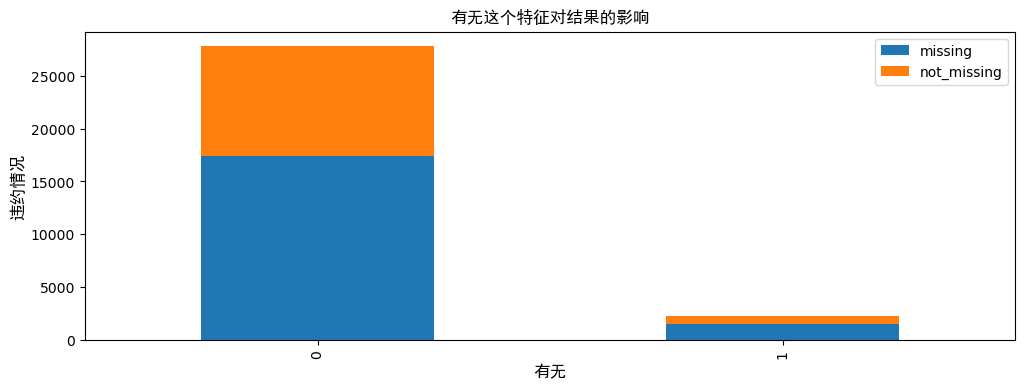

In [151]:
## 处理UserInfo_12缺失
train_master['UserInfo_12'].unique()
#fig = plt.figure()
#fig.set(alpha=0.2)
target_UserInfo_12_not = train_master.target[train_master.UserInfo_12.isnull()].value_counts()
target_UserInfo_12_ = train_master.target[train_master.UserInfo_12.notnull()].value_counts()
df_UserInfo_12 = pd.DataFrame({'missing':target_UserInfo_12_not,'not_missing':target_UserInfo_12_})
df_UserInfo_12
df_UserInfo_12.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [152]:
train_master.loc[(train_master.UserInfo_12.isnull() , 'UserInfo_12')] = 2.0
#train_master['UserInfo_11'].fillna(2.0)
#train_master['UserInfo_12'] =train_master['UserInfo_12'].astype(np.int32)
train_master['UserInfo_12'].dtypes
train_master['UserInfo_12'].unique()

dtype('float64')

array([2., 0., 1.])

array([nan,  0.,  1.])

,no_have,have
target,,
0,17386,10416
1,1523,675


<Axes: xlabel='target'>

Text(0.5, 1.0, '有无这个特征对结果的影响')

Text(0.5, 0, '有无')

Text(0, 0.5, '违约情况')

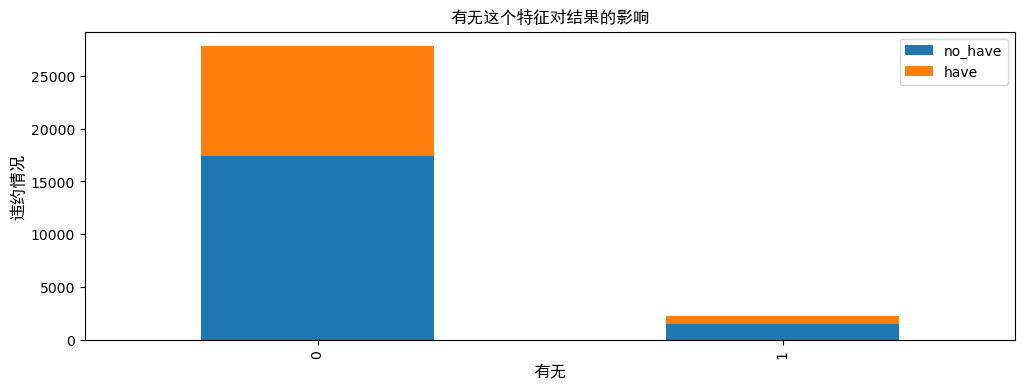

In [153]:
## 处理UserInfo_11缺失
train_master['UserInfo_11'].unique()
#fig = plt.figure()
#fig.set(alpha=0.2)
target_UserInfo_11_not = train_master.target[train_master.UserInfo_11.isnull()].value_counts()
target_UserInfo_11_ = train_master.target[train_master.UserInfo_11.notnull()].value_counts()
df_UserInfo_11 = pd.DataFrame({'no_have':target_UserInfo_11_not,'have':target_UserInfo_11_})
df_UserInfo_11
df_UserInfo_11.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [154]:
#train_master['UserInfo_11'] =train_master['UserInfo_11'].astype(str)
train_master.loc[(train_master.UserInfo_11.isnull() , 'UserInfo_11')] = 2.0
train_master['UserInfo_11'].unique()

array([2., 0., 1.])

array([nan,  1.,  0.])

,no_have,have
target,,
0,17386,10416
1,1523,675


<Axes: xlabel='target'>

Text(0.5, 1.0, '有无这个特征对结果的影响')

Text(0.5, 0, '有无')

Text(0, 0.5, '违约情况')

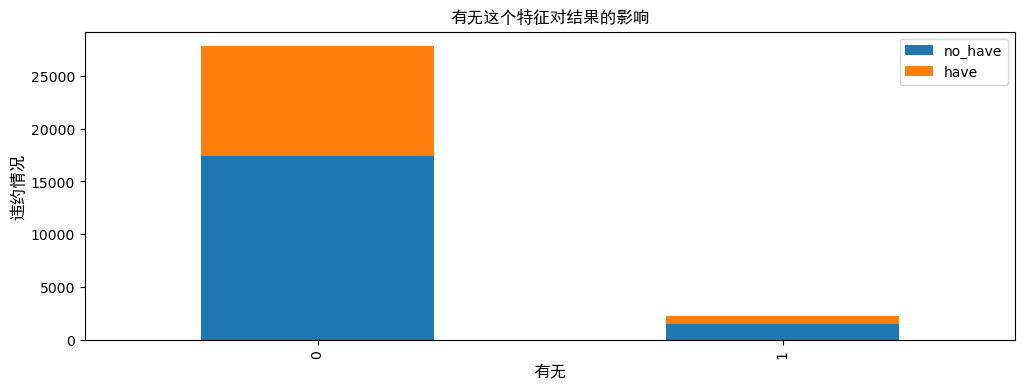

In [155]:
## 处理UserInfo_13缺失
train_master['UserInfo_13'].unique()
#fig = plt.figure()
#fig.set(alpha=0.2)
target_UserInfo_13_not = train_master.target[train_master.UserInfo_13.isnull()].value_counts()
target_UserInfo_13_ = train_master.target[train_master.UserInfo_13.notnull()].value_counts()
df_UserInfo_13 = pd.DataFrame({'no_have':target_UserInfo_13_not,'have':target_UserInfo_13_})
df_UserInfo_13
df_UserInfo_13.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [156]:
#train_master['UserInfo_13'] =train_master['UserInfo_13'].astype(str)
train_master.loc[(train_master.UserInfo_13.isnull() , 'UserInfo_13')] = 2.0
train_master['UserInfo_13'].unique()

array([2., 1., 0.])

array(['I5', nan, 'I4', 'C19', 'I3', 'U', 'C21', 'C20', 'F13', 'C1',
       'C11', 'C12', 'C18', 'C15', 'O', 'C17', 'F12', 'F9', 'C16', 'I10',
       'C13', 'F11', 'F16', 'F7', 'C14', 'I6', 'F14', 'F10', 'C38', 'F15',
       'I11', 'I7', 'C39', 'F6', 'F3', 'C32', 'I8'], dtype=object)

,no_have,have
target,,
0,7565,20237
1,485,1713


<Axes: xlabel='target'>

Text(0.5, 1.0, '有无这个特征对结果的影响')

Text(0.5, 0, '有无')

Text(0, 0.5, '违约情况')

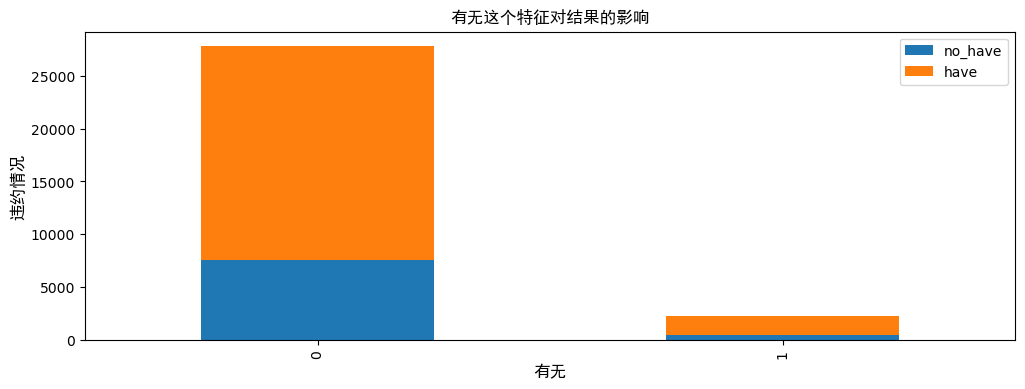

In [157]:
## 处理WeblogInfo_20 缺失
train_master['WeblogInfo_20'].unique()
#fig = plt.figure()
#fig.set(alpha=0.2)
target_WeblogInfo_20_not = train_master.target[train_master.WeblogInfo_20.isnull()].value_counts()
target_WeblogInfo_20_ = train_master.target[train_master.WeblogInfo_20.notnull()].value_counts()
df_WeblogInfo_20 = pd.DataFrame({'no_have':target_WeblogInfo_20_not,'have':target_WeblogInfo_20_})
df_WeblogInfo_20
df_WeblogInfo_20.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [158]:
#train_master['WeblogInfo_20'] =train_master['WeblogInfo_20'].astype(str)
train_master.loc[(train_master.WeblogInfo_20.isnull() , 'WeblogInfo_20')] = u'不详'
train_master['WeblogInfo_20'].unique()

array(['I5', '不详', 'I4', 'C19', 'I3', 'U', 'C21', 'C20', 'F13', 'C1',
       'C11', 'C12', 'C18', 'C15', 'O', 'C17', 'F12', 'F9', 'C16', 'I10',
       'C13', 'F11', 'F16', 'F7', 'C14', 'I6', 'F14', 'F10', 'C38', 'F15',
       'I11', 'I7', 'C39', 'F6', 'F3', 'C32', 'I8'], dtype=object)

In [159]:
train_master['WeblogInfo_19'].unique()
#fig = plt.figure()
#fig.set(alpha=0.2)
target_WeblogInfo_19_not = train_master.target[train_master.WeblogInfo_19.isnull()].value_counts()
target_WeblogInfo_19_ = train_master.target[train_master.WeblogInfo_19.notnull()].value_counts()
df_WeblogInfo_19 = pd.DataFrame({'no_have':target_WeblogInfo_19_not,'have':target_WeblogInfo_19_})
df_WeblogInfo_19

#df_WeblogInfo_19.plot(kind='bar', stacked=True)
#plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
#plt.xlabel(u'有无', fontproperties=myfont)
#plt.ylabel(u'违约情况', fontproperties=myfont)
#plt.show()

#train_master['WeblogInfo_19'] =train_master['WeblogInfo_19'].astype(str)
train_master.loc[(train_master.WeblogInfo_19.isnull() , 'WeblogInfo_19')] = u'不详'
train_master['WeblogInfo_19'].unique()

array(['I', 'E', 'F', 'D', 'J', 'G', 'H', nan], dtype=object)

,no_have,have
target,,
0,2771,25031
1,192,2006


array(['I', 'E', 'F', 'D', 'J', 'G', 'H', '不详'], dtype=object)

array(['D', 'C', 'A', 'B', nan], dtype=object)

,no_have,have
target,,
0,2878,24924
1,196,2002


<Axes: xlabel='target'>

Text(0.5, 1.0, '有无这个特征对结果的影响')

Text(0.5, 0, '有无')

Text(0, 0.5, '违约情况')

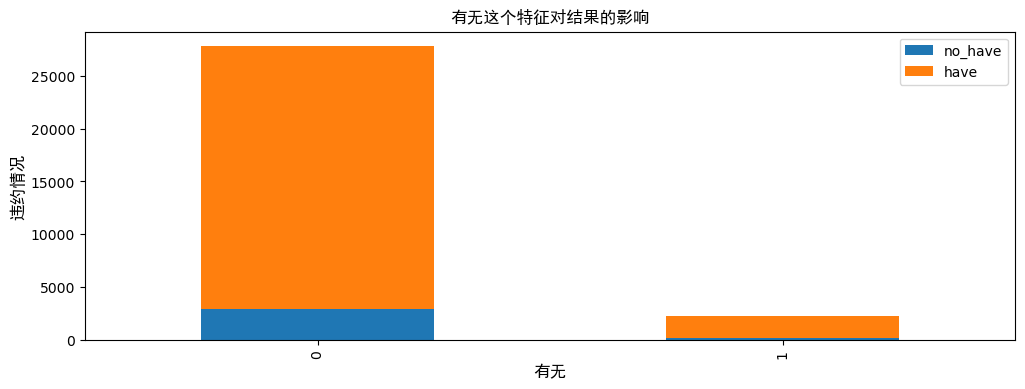

In [160]:
## 处理WeblogInfo_21 缺失
train_master['WeblogInfo_21'].unique()
#fig = plt.figure()
#fig.set(alpha=0.2)
target_WeblogInfo_21_not = train_master.target[train_master.WeblogInfo_21.isnull()].value_counts()
target_WeblogInfo_21_ = train_master.target[train_master.WeblogInfo_21.notnull()].value_counts()
df_WeblogInfo_21 = pd.DataFrame({'no_have':target_WeblogInfo_21_not,'have':target_WeblogInfo_21_})
df_WeblogInfo_21

df_WeblogInfo_21.plot(kind='bar', stacked=True)
plt.title(u'有无这个特征对结果的影响', fontproperties=myfont)
plt.xlabel(u'有无', fontproperties=myfont)
plt.ylabel(u'违约情况', fontproperties=myfont)
plt.show()

In [161]:
#train_master['WeblogInfo_21'] =train_master['WeblogInfo_21'].astype(str)
train_master.loc[(train_master.WeblogInfo_21.isnull() , 'WeblogInfo_21')] = '0'
train_master['WeblogInfo_21'].unique()

array(['D', 'C', 'A', 'B', '0'], dtype=object)

### 数据预处理与特征工程

In [162]:
## 其余缺失值很少的就用均值或众数填充
len(train_master['UserInfo_2'].value_counts()) ## 城市地理位置
len(train_master['UserInfo_4'].value_counts())## 城市地理位置
len(train_master['UserInfo_8'].value_counts())## 城市地理位置
len(train_master['UserInfo_9'].unique())## 城市地理位置
len(train_master['UserInfo_20'].value_counts())## 城市地理位置
len(train_master['UserInfo_7'].unique())## 省份地理位置
len(train_master['UserInfo_19'].unique())## 省份地理位置

# 如果选择以0填充，下述部分就维持现状，如果选择中位数/众数填充，就把下述的部分注释掉
# train_master.loc[(train_master.UserInfo_2.isnull() , 'UserInfo_2')] = '0'
# train_master.loc[(train_master.UserInfo_4.isnull() , 'UserInfo_4')] = '0'
# train_master.loc[(train_master.UserInfo_8.isnull() , 'UserInfo_8')] = '0'
# train_master.loc[(train_master.UserInfo_9.isnull() , 'UserInfo_9')] = '0'
# train_master.loc[(train_master.UserInfo_20.isnull() , 'UserInfo_20')] = '0'
# train_master.loc[(train_master.UserInfo_7.isnull() , 'UserInfo_7')] = '0'
# train_master.loc[(train_master.UserInfo_19.isnull() , 'UserInfo_19')] = '0'

327

330

655

7

297

32

31

In [163]:
## 用众数填充缺失值
categoric_cols = ['UserInfo_1' ,'UserInfo_2' ,'UserInfo_3' ,'UserInfo_4' , 'UserInfo_5' ,'UserInfo_6','UserInfo_7','UserInfo_8','UserInfo_9','UserInfo_11','UserInfo_12','UserInfo_13','UserInfo_14','UserInfo_15','UserInfo_16','UserInfo_17','UserInfo_19','UserInfo_20','UserInfo_21','UserInfo_22','UserInfo_23','UserInfo_24','Education_Info1','Education_Info2','Education_Info3','Education_Info4','Education_Info5','Education_Info6','Education_Info7','Education_Info8','WeblogInfo_19','WeblogInfo_20','WeblogInfo_21','SocialNetwork_1','SocialNetwork_2','SocialNetwork_7','SocialNetwork_12']
# for col in categoric_cols:
#     mode_cols = train_master[col].mode()[0]
#     train_master.loc[(train_master[col].isnull() , col)] = mode_cols 
    
## 用均值填充缺失值 
numeric_cols = []
for col in train_master.columns:
    if col not in categoric_cols and col !=u'Idx' and col !=u'target' and col !='ListingInfo':
        mean_cols = train_master[col].mean()
        train_master.loc[(train_master[col].isnull() , col)] = mean_cols   
  
y_train = train_master['target'].values

In [164]:
import re
## 去掉空格
train_master['UserInfo_9'] = train_master['UserInfo_9'].apply(lambda x: x.strip())
## 去掉大小写
train_userupdateinfo['UserupdateInfo1'] =train_userupdateinfo['UserupdateInfo1'].apply(lambda x:x.lower())
## 将UserInfo_8中城市名归一化
def encodingstr(s):
    regex = re.compile(r'.+市')
    if regex.search(s):
        s = s[:-1]
        return s
    else:
        return s
train_master['UserInfo_8'] =train_master['UserInfo_8'].apply(lambda x: encodingstr(x))
train_userupdateinfo.to_csv('./train_userupdateinfo.csv',index=False,encoding='utf-8')

In [165]:
## UserInfo_2处理
dummies_UserInfo_2 = pd.get_dummies(train_master['UserInfo_2'] , prefix='UserInfo_2')
dummies_UserInfo_2.head()
dummies_UserInfo_2.shape

,UserInfo_2_七台河,UserInfo_2_三明,UserInfo_2_三门峡,UserInfo_2_上海,UserInfo_2_上饶,UserInfo_2_东莞,UserInfo_2_东营,UserInfo_2_中山,UserInfo_2_临夏回族自治州,UserInfo_2_临汾,...,UserInfo_2_鹰潭,UserInfo_2_黄冈,UserInfo_2_黄山,UserInfo_2_黄石,UserInfo_2_黑河,UserInfo_2_黔东南,UserInfo_2_黔南,UserInfo_2_黔西南,UserInfo_2_齐齐哈尔,UserInfo_2_龙岩
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


(30000, 327)

In [166]:
## 剔除标准差几乎为零的特征项
feature_std = train_master.std().sort_values(ascending=True)
feature_std.head(20)
train_master.drop([],axis=1,inplace=True)
train_master['Idx'] =train_master['Idx'].astype(np.int32)

for i in range(25):
    name = 'UserInfo_'+str(i)
    try:
        print(train_master[name].head())
    except:
        pass
        
train_master['UserInfo_8'].head(20)

TypeError: could not convert string to float: '深圳'

### 建模与特征重要度

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn import metrics
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

def modelfit(alg, dtrain,y_train, dtest=None ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values[:,:], label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds ,early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #建模
    alg.fit(dtrain.values[: ,:], y_train ,eval_metric='auc')
        
    #对训练集预测
    dtrain_predictions = alg.predict(dtrain.values[: ,:])
    dtrain_predprob = alg.predict_proba(dtrain.values[: ,:])[:,1]
        
    #输出模型的一些结果
    #print(dtrain_predictions)
    #print(alg.predict_proba(dtrain.as_matrix()[: ,1:]))
    print(cvresult.shape[0])
    print("\n关于现在这个模型")
    print("准确率 : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC 得分 (训练集): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    print(feat_imp.head(25))
    print(feat_imp.shape)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
xgb1 = XGBClassifier(
            learning_rate=0.1,
            n_estimators =100,
            max_depth=7,
            min_child_weight =1,
            gamma = 0,
            subsample=0.8,
            colsample_bytree = 0.8,
            objective ='binary:logistic' ,
            nthread=4,
            scale_pos_weight=1,
            seed = 27
            )

modelfit(xgb1 ,dummies_UserInfo_2  ,y_train)

### 继续特征工程

(此处省略一万步)

In [ ]:
## 借款成交时间处理
grouped_date_1 = train_master[train_master.target ==1.0]['target'].groupby(train_master['ListingInfo']).count()
grouped_date_1.sort_values(ascending=False)
grouped_date_0 = train_master[train_master.target ==0.0]['target'].groupby(train_master['ListingInfo']).count()
grouped_date_0.sort_values(ascending=False)
plt.figure()
plt.title(u'date')
grouped_date_1.plot(color='r')
grouped_date_0.plot(color='b')
plt.show()

In [167]:
## 借款日期离散化
# 把月、日、单独拎出来，放到3列中
train_master['month'] = pd.DatetimeIndex(train_master.ListingInfo).month
train_master['day']  = pd.DatetimeIndex(train_master.ListingInfo).day
train_master['day'].head()
train_master.drop(['ListingInfo'],axis=1,inplace=True)
train_master['target'] = train_master['target'].astype(str)
train_master.to_csv('./train_master.csv',index=False,encoding='utf-8')

0     5
1    26
2    28
3    25
4    27
Name: day, dtype: int32

In [168]:
train_master

,Idx,UserInfo_1,UserInfo_2,UserInfo_3,UserInfo_4,WeblogInfo_2,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,...,SocialNetwork_11,SocialNetwork_12,SocialNetwork_13,SocialNetwork_14,SocialNetwork_15,SocialNetwork_16,SocialNetwork_17,target,month,day
0,10001,1.0,深圳,4.0,深圳,1.000000,1.000000,1.00000,1.000000,14.0,...,-1.0,0,0.0,0.0,0.0,0.0,1.0,0,3,5
1,10002,1.0,温州,4.0,温州,0.000000,1.000000,1.00000,1.000000,14.0,...,-1.0,0,0.0,0.0,0.0,0.0,2.0,0,2,26
2,10003,1.0,宜昌,3.0,宜昌,0.000000,2.000000,2.00000,2.000000,9.0,...,-1.0,-1,1.0,0.0,0.0,0.0,0.0,0,2,28
3,10006,4.0,南平,1.0,南平,0.131466,3.025962,1.81696,2.948711,2.0,...,-1.0,-1,0.0,0.0,0.0,0.0,0.0,0,2,25
4,10007,5.0,辽阳,1.0,辽阳,0.000000,1.000000,1.00000,1.000000,3.0,...,-1.0,-1,0.0,0.0,0.0,0.0,0.0,0,2,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,9991,3.0,南阳,4.0,南阳,1.000000,3.000000,2.00000,3.000000,10.0,...,-1.0,0,1.0,0.0,0.0,0.0,1.0,0,2,22
29996,9992,3.0,宁德,4.0,泉州,0.000000,6.000000,1.00000,6.000000,16.0,...,-1.0,0,0.0,0.0,0.0,0.0,1.0,0,2,28
29997,9995,1.0,天津,2.0,天津,0.000000,2.000000,2.00000,2.000000,4.0,...,-1.0,-1,0.0,0.0,0.0,0.0,0.0,0,2,24
29998,9997,3.0,运城,3.0,运城,0.000000,1.000000,1.00000,1.000000,16.0,...,-1.0,0,1.0,0.0,0.0,0.0,1.0,0,2,28


In [169]:
from collections import defaultdict
import datetime as dt
##  userupdateinfo表
userupdate_info_number = defaultdict(list) ### 用户信息更新的次数
userupdate_info_category = defaultdict(set) ###用户信息更新的种类数
userupdate_info_times = defaultdict(list) ### 用户分几次更新了
userupdate_info_date = defaultdict(list) #### 用户借款成交与信息更新时间跨度

In [170]:
with open('./train_userupdateinfo.csv' ,'r') as f:
    f.readline()
    for line in f.readlines():
        cols = line.strip().split(",") ### cols 是list结果
        userupdate_info_date[cols[0]].append(cols[1])
        userupdate_info_number[cols[0]].append(cols[2])
        userupdate_info_category[cols[0]].add(cols[2])
        userupdate_info_times[cols[0]].append(cols[3])
    print(u'提取信息完成')

userupdate_info_number_ = defaultdict(int) ### 用户信息更新的次数
userupdate_info_category_ = defaultdict(int) ### 用户信息更新的种类数
userupdate_info_times_ = defaultdict(int) ### 用户分几次更新了
userupdate_info_date_ = defaultdict(int) #### 用户借款成交与信息更新时间跨度

'Idx,ListingInfo1,UserupdateInfo1,UserupdateInfo2\n'

提取信息完成


In [171]:
for key in userupdate_info_date.keys():
    userupdate_info_times_[key] = len(set(userupdate_info_times[key]))
    delta_date = dt.datetime.strptime(userupdate_info_date[key][0] ,'%Y/%m/%d') - dt.datetime.strptime(list(set(userupdate_info_times[key]))[0] ,'%Y/%m/%d')
    userupdate_info_date_[key] = abs(delta_date.days)
    userupdate_info_number_[key] = len(userupdate_info_number[key])
    userupdate_info_category_[key] = len(userupdate_info_category[key])

print('信息处理完成')

信息处理完成


In [172]:
## 建立一个DataFrame
Idx_ = list(userupdate_info_date_.keys()) #### list
numbers_ = list(userupdate_info_number_.values())
categorys_ = list(userupdate_info_category_.values())
times_ = list(userupdate_info_times_.values())
dates_ = list(userupdate_info_date_.values())
userupdate_df = pd.DataFrame({'Idx':Idx_ , 'numbers':numbers_ ,'categorys':categorys_ ,'times':times_ ,'dates':dates_ })
userupdate_df.head()
userupdate_df.to_csv('./userupdate_df.csv',index=False,encoding='utf-8')

,Idx,numbers,categorys,times,dates
0,10001,11,10,1,13
1,10002,21,15,3,233
2,10003,10,9,1,8
3,10006,10,9,1,5
4,10007,10,10,2,8


（省略LogInfo表的处理）

### 建模调参与优化

In [139]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.model_selection import cross_validate, GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import sklearn.preprocessing as preprocessing
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [130]:
train_master = pd.read_csv('./train_master.csv',encoding='utf-8')
train_userupdateinfo = pd.read_csv('./userupdate_df.csv',encoding='utf-8')
#train_loginfo = pd.read_csv('./loginfo_df.csv',encoding='utf-8')

In [173]:
# train_all = pd.merge(train_master, train_userupdateinfo, how='left', on='Idx')
#train_all = pd.merge(train_all, train_loginfo, how='left', on='Idx')
train_all=train_master
train_all.isnull().sum().sort_values(ascending=False).head(10)

UserInfo_2                    302
UserInfo_4                    268
UserInfo_3                      7
UserInfo_1                      6
Idx                             0
ThirdParty_Info_Period4_13      0
ThirdParty_Info_Period4_17      0
ThirdParty_Info_Period4_16      0
ThirdParty_Info_Period4_15      0
ThirdParty_Info_Period4_14      0
dtype: int64

In [174]:
## 填充缺失值


In [175]:
## 对数值型特征进行scaling
import warnings
warnings.filterwarnings("ignore")


In [176]:
train_all['Idx'] = train_all['Idx'].astype(np.int64)
train_all['target'] = train_all['target'].astype(np.int64)
train_all = pd.get_dummies(train_all)
train_all.head()
train_all.to_csv('./train_all.csv',encoding='utf-8',index=False)
y_train = train_all.pop('target')

,Idx,UserInfo_1,UserInfo_3,WeblogInfo_2,WeblogInfo_4,WeblogInfo_5,WeblogInfo_6,WeblogInfo_7,WeblogInfo_8,WeblogInfo_9,...,WeblogInfo_20_I7,WeblogInfo_20_I8,WeblogInfo_20_O,WeblogInfo_20_U,WeblogInfo_20_不详,WeblogInfo_21_0,WeblogInfo_21_A,WeblogInfo_21_B,WeblogInfo_21_C,WeblogInfo_21_D
0,10001,1.0,4.0,1.000000,1.000000,1.00000,1.000000,14.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
1,10002,1.0,4.0,0.000000,1.000000,1.00000,1.000000,14.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
2,10003,1.0,3.0,0.000000,2.000000,2.00000,2.000000,9.0,3.0,0.0,...,False,False,False,False,False,False,False,False,False,True
3,10006,4.0,1.0,0.131466,3.025962,1.81696,2.948711,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,True
4,10007,5.0,1.0,0.000000,1.000000,1.00000,1.000000,3.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True


In [134]:
def modelfit(alg, dtrain,y_train, dtest=None ,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values[: ,1:], label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds ,early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #建模
    alg.fit(dtrain.values[: ,1:], y_train ,eval_metric='auc')
        
    #对训练集预测
    dtrain_predictions = alg.predict(dtrain.values[: ,1:])
    dtrain_predprob = alg.predict_proba(dtrain.values[: ,1:])[:,1]
        
    #输出模型的一些结果
    print(cvresult.shape[0])
    print("\n关于现在这个模型")
    print("准确率 : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC 得分 (训练集): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
    
                
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    print(feat_imp.head(25))
    print(feat_imp.shape)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

100

关于现在这个模型
准确率 : 0.9298
AUC 得分 (训练集): 0.934382
f204    172.0
f90     133.0
f99     124.0
f133    122.0
f103    120.0
f28     117.0
f5      111.0
f87     111.0
f89     110.0
f107    108.0
f140    108.0
f106    103.0
f136    102.0
f120    102.0
f86      97.0
f205     97.0
f70      94.0
f73      93.0
f123     93.0
f85      91.0
f97      90.0
f101     86.0
f116     86.0
f6       86.0
f24      86.0
dtype: float64
(367,)


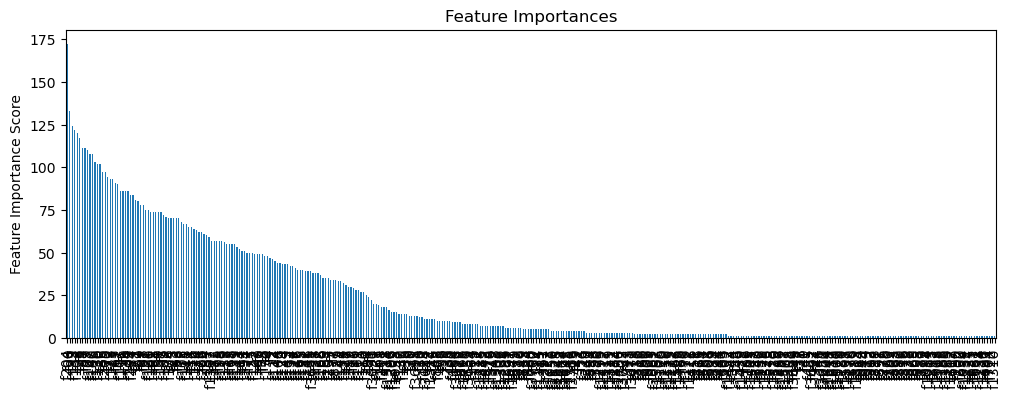

In [135]:
xgb1 = XGBClassifier(
            learning_rate=0.03,
            n_estimators =100,
            max_depth=7,
            min_child_weight =1,
            gamma =0,
            subsample=0.8,
            colsample_bytree =0.8,
            objective ='binary:logistic' ,
            nthread=4,
            scale_pos_weight=1,
            seed =27
            )

modelfit(xgb1 ,train_all  ,y_train)

In [141]:
testdata=pd.read_csv('test_all.csv')
ypred=xgb1.predict(testdata)

ValueError: Feature shape mismatch, expected: 3704, got 3668

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
rf0 = RandomForestClassifier(oob_score=True , random_state =42)
rf0.fit(train_all.values[:,1:] ,y_train)
print(rf0.oob_score_)
y_predprob = rf0.predict_proba(train_all.values[:,1:])[:,1]
print('AUC Score(Train): %f'%metrics.roc_auc_score(y_train , y_predprob))

In [ ]:
import warnings
warnings.filterwarnings("ignore")
lr = LogisticRegression(tol=1e-6)
parameters = {'penalty':('l1' , 'l2') , 'C':[,]}
clf_lr = GridSearchCV(lr ,parameters, cv=3)
print('开始训练')
clf_lr.fit(train_all.values[:,1:] ,y_train)
print('模型训练结束')
clf_lr

In [ ]:
import warnings
warnings.filterwarnings("ignore")
clf_lr_accuracy = clf_lr.score(train_all.values[:,1:] ,y_train)
print(clf_lr_accuracy)
clf_lr.cv_results_ , clf_lr.best_params_ ,clf_lr.best_score_